In [6]:
import numpy as np
import matplotlib.pyplot as plt
import re
import struct

NUMPAT = '[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?'

In [2]:
def run(x, y, filenames):
    global LASTPATH
    LASTPATH = os.path.dirname(filenames[0])
    arrays, headers, extra = groupUnpack(filenames)

    #One final step before we're done - let's try to sort based on the sim time
    #using a standard decorate-sort-undecorate, with a twist for the variable number of keys

    #Let's start by finding the original indices - making a copy is key
    originalTimeIndex = list(extra["SimTime"])
    if len(set(extra["MIFSource"])) == 1:
        if not -1 in extra["SimTime"]:
            extra["SimTime"], arrays = zip(*sorted(zip(originalTimeIndex, arrays)))
            #Sadly, the cleverness ends here - the rest must be bruteforced.
            for key in extra:
                if not key == "SimTime": #We did that one.
                    junk, extra[key] = zip(*sorted(zip(originalTimeIndex, extra[key])))
    gatherData(arrays, headers, extra)

def groupUnpack(targetlist):
    progdialog = None
    decodedArrays = []
    headers = {}
    extraData = defaultdict(list)
    firstTime = True
    for target in targetlist:
        collect = unpackFile(target)
        if firstTime:
            firstTime = False
            headers = collect[1]
        decodedArrays.append(collect[0])
        #Unpack extra collected data
        for key, value in collect[2].iteritems():
            extraData[key].append(value)
    return (np.array(decodedArrays), headers, extraData)

def unpackFile(filename):
    with open(filename, 'rb') as f:
        headers = {} #I know valuemultiplier isn't always present. This is checked later.
        extraCaptures = {'SimTime':-1, 'Iteration':-1, 'Stage':-1, "MIFSource":""}
        #Parse headers
        a = ""
        while not "Begin: Data" in a:
            a = f.readline().strip()
            #Determine if it's actually something we need as header data
            for key in ["xbase", "ybase", "zbase", "xstepsize", "ystepsize", "zstepsize", "xnodes", "ynodes", "znodes", "valuemultiplier"]:
                if key in a:
                    headers[key] = float(a.split()[2]) #Known position FTW
            #All right, it may also be time data, which we should capture
            if "Total simulation time" in a:
                #Split on the colon to get the time with units; strip spaces and split on the space to separate time and units
                #Finally, pluck out the time, stripping defensively (which should be unnecessary).
                extraCaptures['SimTime'] = float(a.split(":")[-1].strip().split()[0].strip())
            if "Iteration:" in a:
                #Another tricky split...
                extraCaptures['Iteration'] = float(a.split(":")[2].split(",")[0].strip())
            if "Stage:" in a:
                extraCaptures['Stage'] = float(a.split(":")[2].split(",")[0].strip())
            if "MIF source file" in a:
                extraCaptures['MIFSource'] = a.split(":",2)[2].strip()


        #Initialize array to be populated
        outArray = np.zeros((int(headers["xnodes"]),
                             int(headers["ynodes"]),
                             int(headers["znodes"]),
                             3))

        #Determine decoding mode and use that to populate the array
        decode = a.split()
        if decode[3] == "Text":
            return _textDecode(f, outArray, headers, extraCaptures)
        elif decode[3] == "Binary" and decode[4] == "4":
            #Determine endianness
            endianflag = f.read(4)
            if struct.unpack(">f", endianflag)[0] == 1234567.0:
                dc = struct.Struct(">f")
            elif struct.unpack("<f", endianflag)[0] == 1234567.0:
                dc = struct.Struct("<f")
            else:
                raise Exception("Can't decode 4-byte byte order mark: " + hex(endianflag))
            return _binaryDecode(f, 4, dc, outArray, headers, extraCaptures)
        elif decode[3] == "Binary" and decode[4] == "8":
            #Determine endianness
            endianflag = f.read(8)
            if struct.unpack(">d", endianflag)[0] == 123456789012345.0:
                dc = struct.Struct(">d")
            elif struct.unpack("<d", endianflag)[0] == 123456789012345.0:
                dc = struct.Struct("<d")
            else:
                raise Exception("Can't decode 8-byte byte order mark: " + hex(endianflag))
            return _binaryDecode(f, 8, dc, outArray, headers, extraCaptures)
        else:
            raise Exception("Unknown OOMMF data format:" + decode[3] + " " + decode[4])



def _textDecode(filehandle, targetarray, headers, extraCaptures):
    valm = headers.get("valuemultiplier",1)
    for k in range(int(headers["znodes"])):
        for j in range(int(headers["ynodes"])):
            for i in range(int(headers["xnodes"])):
                #numpy is fantastic - splice in a tuple
                text = filehandle.readline().strip().split()
                targetarray[i,j,k] = (float(text[0])*valm, float(text[1])*valm, float(text[2])*valm)
    return (targetarray, headers, extraCaptures)


def _binaryDecode(filehandle, chunksize, decoder, targetarray, headers, extraCaptures):
    valm = headers.get("valuemultiplier",1)
    for k in range(int(headers["znodes"])):
        for j in range(int(headers["ynodes"])):
            for i in range(int(headers["xnodes"])):
                for coord in range(3): #Slowly populate, coordinate by coordinate
                    targetarray[i,j,k,coord] = decoder.unpack(filehandle.read(chunksize))[0] * valm
    return (targetarray, headers, extraCaptures)

def pickleArray(array, headers, extraCaptures, filename):
    temp = dict(headers)
    temp.update(extraCaptures)
    f = open(filename,'w')
    pickle.dump((array,temp), f)
    f.close()

def matlabifyArray(array, headers, extraCaptures, filename):
    GridSize = np.array([float(headers["xstepsize"]), float(headers["ystepsize"]), float(headers["zstepsize"])])
    OutDict = {"OOMMFData":array, "GridSize":GridSize}
    OutDict.update(extraCaptures)
    spio.savemat(filename, OutDict)

def slowlyPainfullyMaximize(filenames):
    """
    This is a special utility function used by OOMMFConvert to find the single largest-magnitude
    vector in a set of vector files
    """
    #There is no nice way to do this.
    def mag(a, b, c):
        return np.sqrt(a**2 + b**2 + c**2)
    maxmag = 0

    for filename in filenames:
        thisArray, headers, extraCaps = unpackFile(filename)
        for k in range(int(headers["znodes"])):
            for j in range(int(headers["ynodes"])):
                for i in range(int(headers["xnodes"])):
                    maxmag = max(maxmag, mag(*thisArray[i,j,k]))
    return maxmag

In [31]:
def unpackFile(filename):
    with open(filename, 'rb') as f:
        headers = {}
        extraCaptures = {'SimTime':-1, 'Iteration':-1, 'Stage':-1, "MIFSource":""}
        
        #Parse headers
        a = ""
        while not "Begin: Data" in a:
            a = str(f.readline().strip())
            #Determine if it's actually something we need as header data
            for key in ["xbase", "ybase", "zbase", "xstepsize", "ystepsize", "zstepsize", "xnodes", "ynodes", "znodes", "valuemultiplier"]:
                if str(key) in a:
                    headers[key] = float(re.search("({})".format(NUMPAT), a).groups()[0])

        #Initialize array to be populated
        outArray = np.zeros((int(headers["xnodes"]),
                             int(headers["ynodes"]),
                             int(headers["znodes"]),
                             3))

        #Determine decoding mode and use that to populate the array
        decode = a.split()
        if decode[3] == "Text":
            return _textDecode(f, outArray, headers, extraCaptures)
        elif decode[3] == "Binary" and decode[4][0] == "4":
            #Determine endianness
            endianflag = f.read(4)
            if struct.unpack(">f", endianflag)[0] == 1234567.0:
                dc = struct.Struct(">f")
            elif struct.unpack("<f", endianflag)[0] == 1234567.0:
                dc = struct.Struct("<f")
            else:
                raise Exception("Can't decode 4-byte byte order mark: " + hex(endianflag))
            return _binaryDecode(f, 4, dc, outArray, headers, extraCaptures)
        elif decode[3] == "Binary" and decode[4] == "8":
            #Determine endianness
            endianflag = f.read(8)
            if struct.unpack(">d", endianflag)[0] == 123456789012345.0:
                dc = struct.Struct(">d")
            elif struct.unpack("<d", endianflag)[0] == 123456789012345.0:
                dc = struct.Struct("<d")
            else:
                raise Exception("Can't decode 8-byte byte order mark: " + hex(endianflag))
            return _binaryDecode(f, 8, dc, outArray, headers, extraCaptures)
        else:
            raise Exception("Unknown OOMMF data format:" + decode[3] + " " + decode[4])



def _textDecode(filehandle, targetarray, headers, extraCaptures):
    valm = headers.get("valuemultiplier",1)
    for k in range(int(headers["znodes"])):
        for j in range(int(headers["ynodes"])):
            for i in range(int(headers["xnodes"])):
                #numpy is fantastic - splice in a tuple
                text = filehandle.readline().strip().split()
                targetarray[i,j,k] = (float(text[0])*valm, float(text[1])*valm, float(text[2])*valm)
    return (targetarray, headers, extraCaptures)


def _binaryDecode(filehandle, chunksize, decoder, targetarray, headers, extraCaptures):
    valm = headers.get("valuemultiplier",1)
    for k in range(int(headers["znodes"])):
        for j in range(int(headers["ynodes"])):
            for i in range(int(headers["xnodes"])):
                for coord in range(3): #Slowly populate, coordinate by coordinate
                    targetarray[i,j,k,coord] = decoder.unpack(filehandle.read(chunksize))[0] * valm
    return (targetarray, headers, extraCaptures)

In [32]:
filename = rb"G:\box\jjirwin\Box Sync\mumax3_output\julian_irwin\save\Ni_pmn-pt_simulations_171214\13_vary_Ku_seed=283634\Ku=0.0\m000046.ovf"

data = unpackFile(filename)

In [11]:
import matplotlib.pyplot

In [12]:
%matplotlib inline

In [26]:
m = data[0].squeeze()

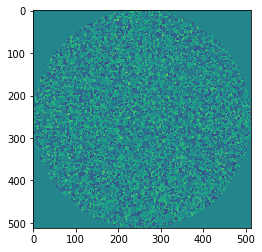

In [28]:
fig, ax = plt.subplots()
ax.imshow(m[:,:,2])
plt.show()

In [ ]:
f